# Importing Libraries

In [2]:
import numpy as np
import cv2
import matplotlib as cm
import matplotlib.pyplot as plt
import os
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import sigma_clipped_stats
import tensorflow as tf
import tensorflow.keras.backend as K
from random import shuffle
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'cv2'

#  Loading pre-trained model

In [3]:
from tensorflow.keras.models import load_model

# Load the full pretrained model
full_model = load_model("/kaggle/input/transient_detection_model/keras/default/1/Transient_detection_model_1.keras")
# Print the model summary to identify which layer to cut off
full_model.summary()

I0000 00:00:1751391245.895530      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751391245.896229      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,795,371 (14.48 MB)

 Trainable params: 1,265,059 (4.83 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2,530,120 (9.65 MB)

# Loading ILMT cutouts of 3 classes for Transfer Learning

In [4]:
DATADIR = "/kaggle/input/transient-datasetilmt/ILMT_images"

CATAGORIES = ["Galaxy_dataset_augmented-ZIP/Galaxy_dataset_augmented-20250609T064714Z-1-001/Galaxy_dataset_augmented", 
              "Stellar_dataset_augmented-ZIP/Stellar_dataset_augmented-20250609T064714Z-1-001/Stellar_dataset_augmented",
              "Asteroid_dataset_augmented-ZIP/Asteroid_dataset_augmented"]

transfer_learning_dataset = []
y=[]
for category in CATAGORIES:
  class_num = CATAGORIES.index(category)
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    arr = np.load(os.path.join(path,img))
      
    transfer_learning_dataset.append(arr[19:82,19:82])
    y.append(class_num)

# Shuffling the orientations

In [5]:
from sklearn.utils import shuffle
transfer_learning_dataset,y=shuffle(transfer_learning_dataset,y)
y[:20]

[0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 2, 1, 1]

# Defining function for z-score normalisation 

In [6]:
def Image_preprocess(img):
  img = img.astype('float32')
  mean = np.mean(img)
  std = np.std(img)
  img_std = (img - mean)/std
  return img_std

# Making the loaded cutouts z-score normalised

In [7]:
X_std=[]
for i in range (len(y)):
    X_std.append(Image_preprocess(transfer_learning_dataset[i]))
print(X_std[1].shape)
# print(X_std)

(63, 63)


# Plotting first 20 cututs with numeric labels

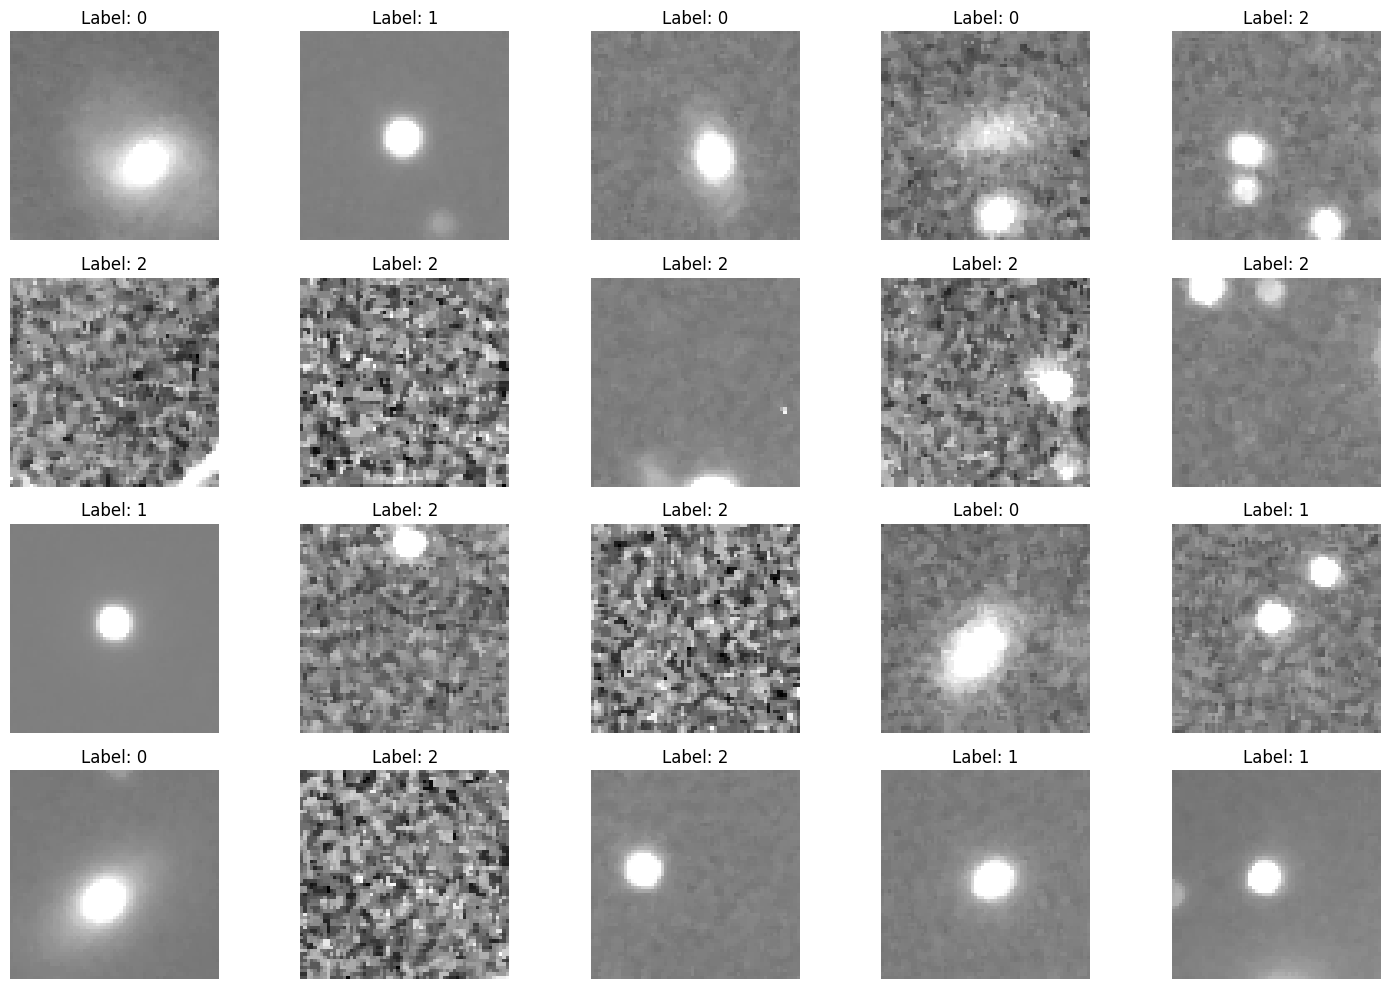

In [8]:

import matplotlib.pyplot as plt
%matplotlib inline
from astropy.stats import sigma_clipped_stats

# Set up the figure

plt.figure(figsize=(15, 10))  

for i in range(20):
    
    plt.subplot(4, 5, i + 1)  # 4 rows and 5 columns
    median=np.median(X_std[i])
    std=np.std(X_std)
    plt.imshow(X_std[i],vmin=median-3*std,vmax=median+3*std,cmap='gray',interpolation='none')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')  # hide axes for clarity

plt.tight_layout()
plt.show()

# Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_std,y,test_size=0.2)

x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

print(len(x_train))
print(len(x_test))

3907
977


# Reshaping for making it deployable to the model

In [10]:
x_train = x_train.reshape(-1, 63, 63, 1)
x_test= x_test.reshape(-1, 63, 63, 1)

# Testing performace on the pre-trained model

In [11]:
full_model.evaluate(np.array(X_std).reshape(-1,63,63,1),np.array(y))

I0000 00:00:1751391361.130244      95 service.cc:148] XLA service 0x7b2d94005150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751391361.130756      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751391361.130776      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751391361.255816      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 63/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5119 - loss: 299.5722

I0000 00:00:1751391362.557863      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4954 - loss: 315.2562


[331.8692932128906, 0.4782964885234833]

# Extracting feature space from the pre-trained model for re-training

In [12]:
from tensorflow.keras import Model, Input

# Rebuild the model manually
x_input = Input(shape=(63, 63,1))


y_layers= x_input

for layer in full_model.layers:  
    y_layers = layer(y_layers)

feature_extractor = Model(inputs=x_input, outputs=y_layers)
# feature_extractor.trainable = False

# Imposing Early-stopping

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='loss',# metric to monitor (usually 'loss' or 'val_accuracy')
    patience=3,         # how many epochs to wait before stopping after no improvement
    min_delta=0.00001,
    restore_best_weights=True  # revert to best model weights after stopping
)

# Transfer Learning

In [14]:
from tensorflow.keras import models, layers

model = models.Sequential([
    feature_extractor
    
])
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)  

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_history=model.fit(x_train,y_train,epochs=50,validation_data=(x_test,y_test))

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.5860 - loss: 3.4419 - val_accuracy: 0.7799 - val_loss: 0.6675
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7692 - loss: 0.7803 - val_accuracy: 0.8588 - val_loss: 0.3762
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8172 - loss: 0.5391 - val_accuracy: 0.8782 - val_loss: 0.3179
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8317 - loss: 0.4620 - val_accuracy: 0.8966 - val_loss: 0.2755
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8508 - loss: 0.3832 - val_accuracy: 0.8987 - val_loss: 0.2645
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8633 - loss: 0.3405 - val_accuracy: 0.9171 - val_loss: 0.2460
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8843 - loss: 0.3324 - val_accuracy: 0.9120 - val_loss: 0.2462
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8808 - loss: 0.3069 - val_accuracy: 

# Plotting accuracy on the training and validation data

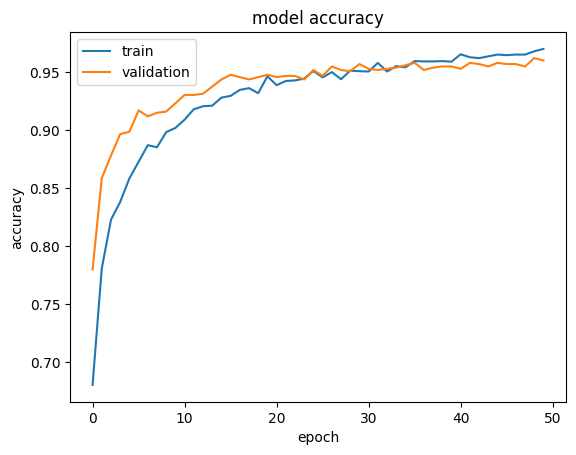

In [41]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Plotting loss on training and validation data

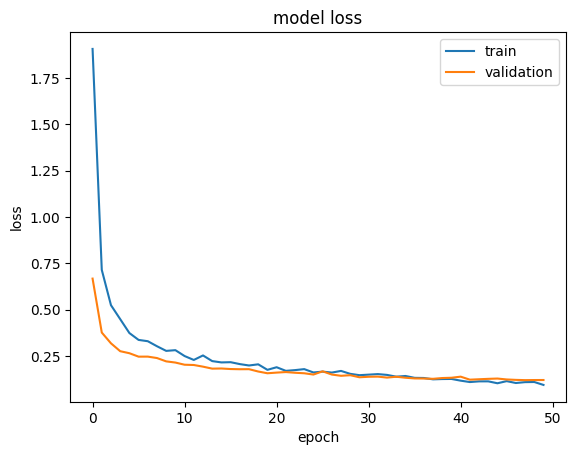

In [46]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim([0,0.4])
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Testing performance

In [48]:
model.evaluate(x_test,y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9593 - loss: 0.1128


[0.11983650922775269, 0.9600818753242493]

# Loading cutouts from downloaded ILMT image with labels

In [49]:
DATADIR = "/kaggle/input/npyilmtcuts63/npy_ILMT_cuts(63)"

CATAGORIES = ["npyILMT_galaxy(63)","npyILMT_star(63)","npyILMT_hostless(63)"]

ILMT_cuts = []
cut_labels=[]
for category in CATAGORIES:
    
    class_num=CATAGORIES.index(category)
    if class_num==0:
        path = os.path.join(DATADIR,category)
        for img in os.listdir(path):
            arr=np.load(os.path.join(path,img))
            ILMT_cuts.append(arr)
            cut_labels.append(class_num)
    else:
        path = os.path.join(DATADIR,category)
        for img in os.listdir(path)[:25]:
            arr=np.load(os.path.join(path,img))
            ILMT_cuts.append(arr)
            cut_labels.append(class_num)


print(len(ILMT_cuts))
print(cut_labels[48:56])

75
[1, 1, 2, 2, 2, 2, 2, 2]


# Shuffling the orientation

In [53]:
from sklearn.utils import shuffle
ILMT_cuts,cut_labels=shuffle(ILMT_cuts,cut_labels)
print(cut_labels[:20])

[2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2, 1]


# Plotting the first 20 cutouts

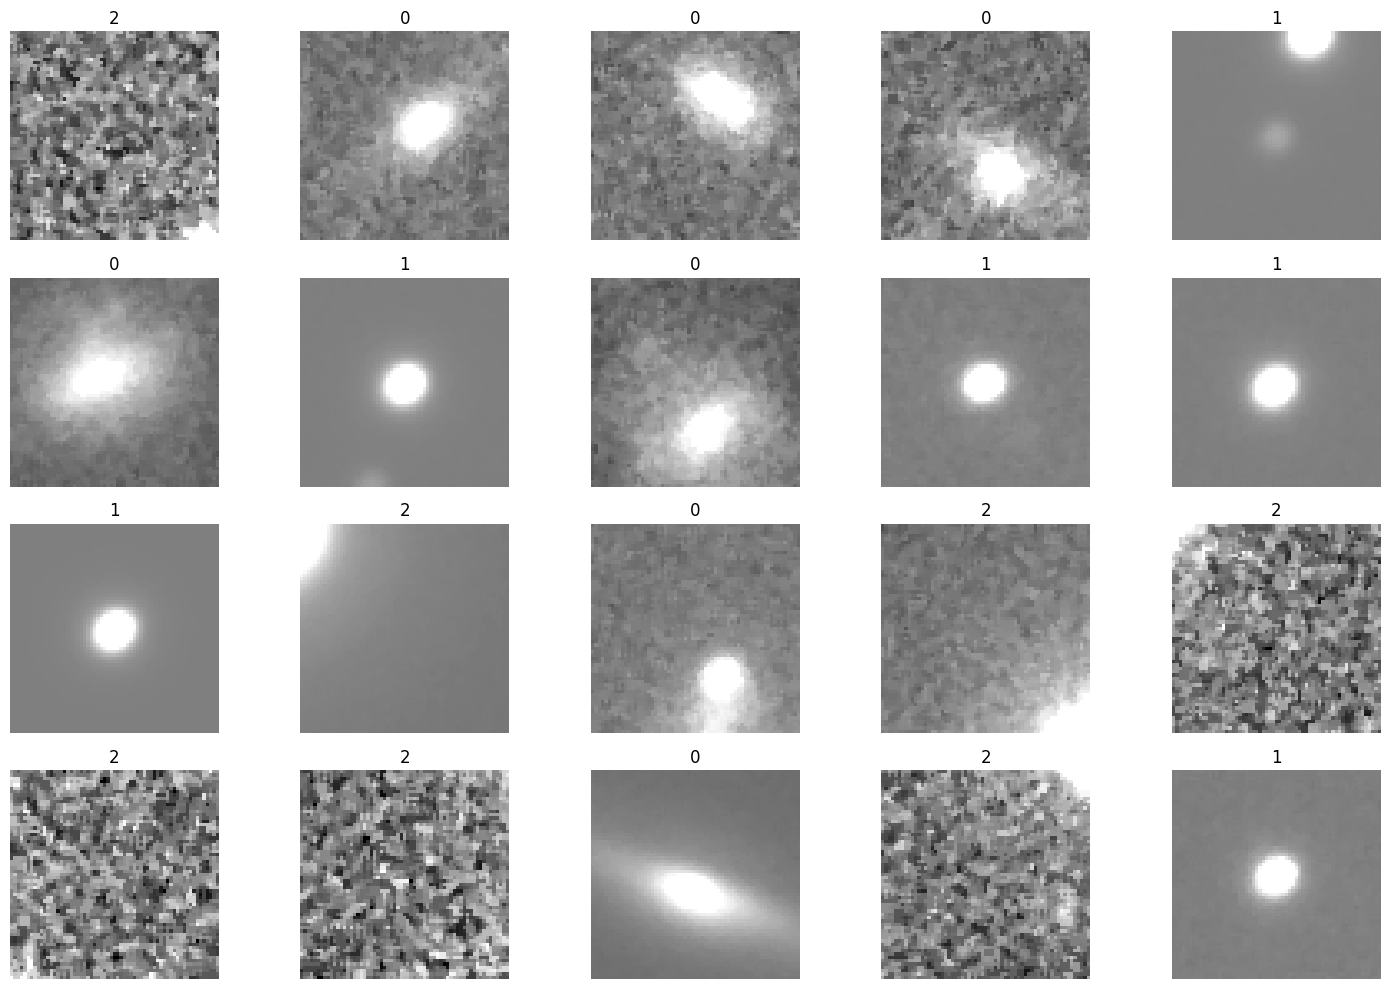

In [54]:

import matplotlib.pyplot as plt
%matplotlib inline
from astropy.stats import sigma_clipped_stats
# Set up the figure
plt.figure(figsize=(15, 10))  

# Plot 20 images in a 4x5 grid

for i in range(20):
    
    plt.subplot(4, 5, i + 1)  # 4 rows, 5 columns
    median=np.median(ILMT_cuts[i])
    mean=np.mean(ILMT_cuts[i])
    plt.imshow(ILMT_cuts[i],vmin=median-3*std,vmax=median+3*std,cmap='gray',interpolation='none')
    plt.title(f"{cut_labels[i]}")
    # plt.title(f"{labels[i]}: {str_label[labels[i]]} ({np.max(predictions[i]):.2f}%)")

    plt.axis('off')  # hiding axes for clarity

plt.tight_layout()
plt.show()

In [55]:
model.evaluate(np.array(ILMT_cuts).reshape(-1,63,63,1),np.array(cut_labels))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9026 - loss: 0.1405


[0.1312793642282486, 0.9066666960716248]

# Predictions on the new cutouts

In [58]:
predictions=model.predict(np.array(ILMT_cuts))
pred_labels=np.argmax(predictions,axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


# Print the Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(np.array(cut_labels),pred_labels)
print(cm)

[[25  0  0]
 [ 1 24  0]
 [ 6  0 19]]


# Visualizing the Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

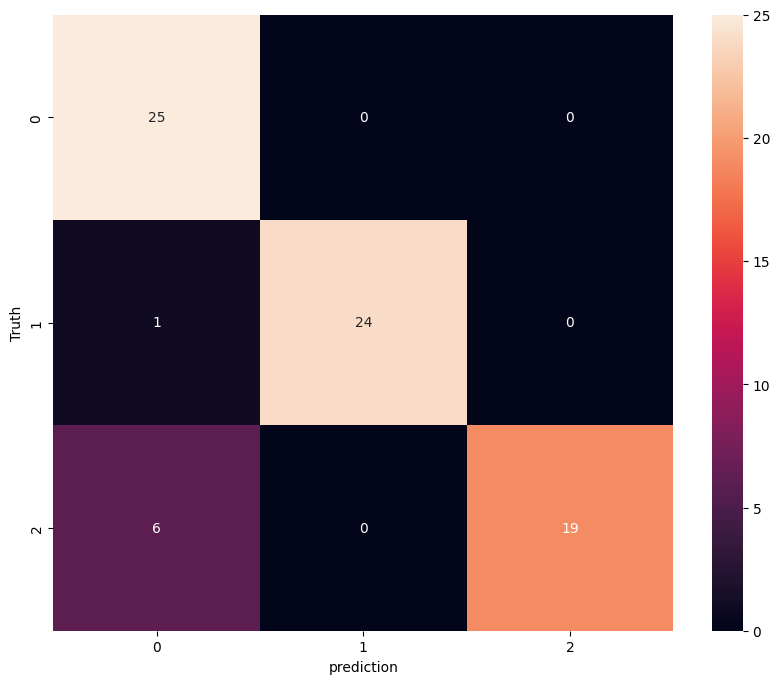

In [60]:
import seaborn as sn
plt.figure(figsize=(10,8))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('prediction')
plt.ylabel('Truth')

# Get the classification report

In [61]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(np.array(cut_labels),pred_labels))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        25
           1       1.00      0.96      0.98        25
           2       1.00      0.76      0.86        25

    accuracy                           0.91        75
   macro avg       0.93      0.91      0.91        75
weighted avg       0.93      0.91      0.91        75



# Adding string labels

In [62]:
str_label=["galaxy","star","hostless"]
print(str_label[0])

galaxy


# Plotting first 20 cutouts with numeric and string labeling with confidence score 

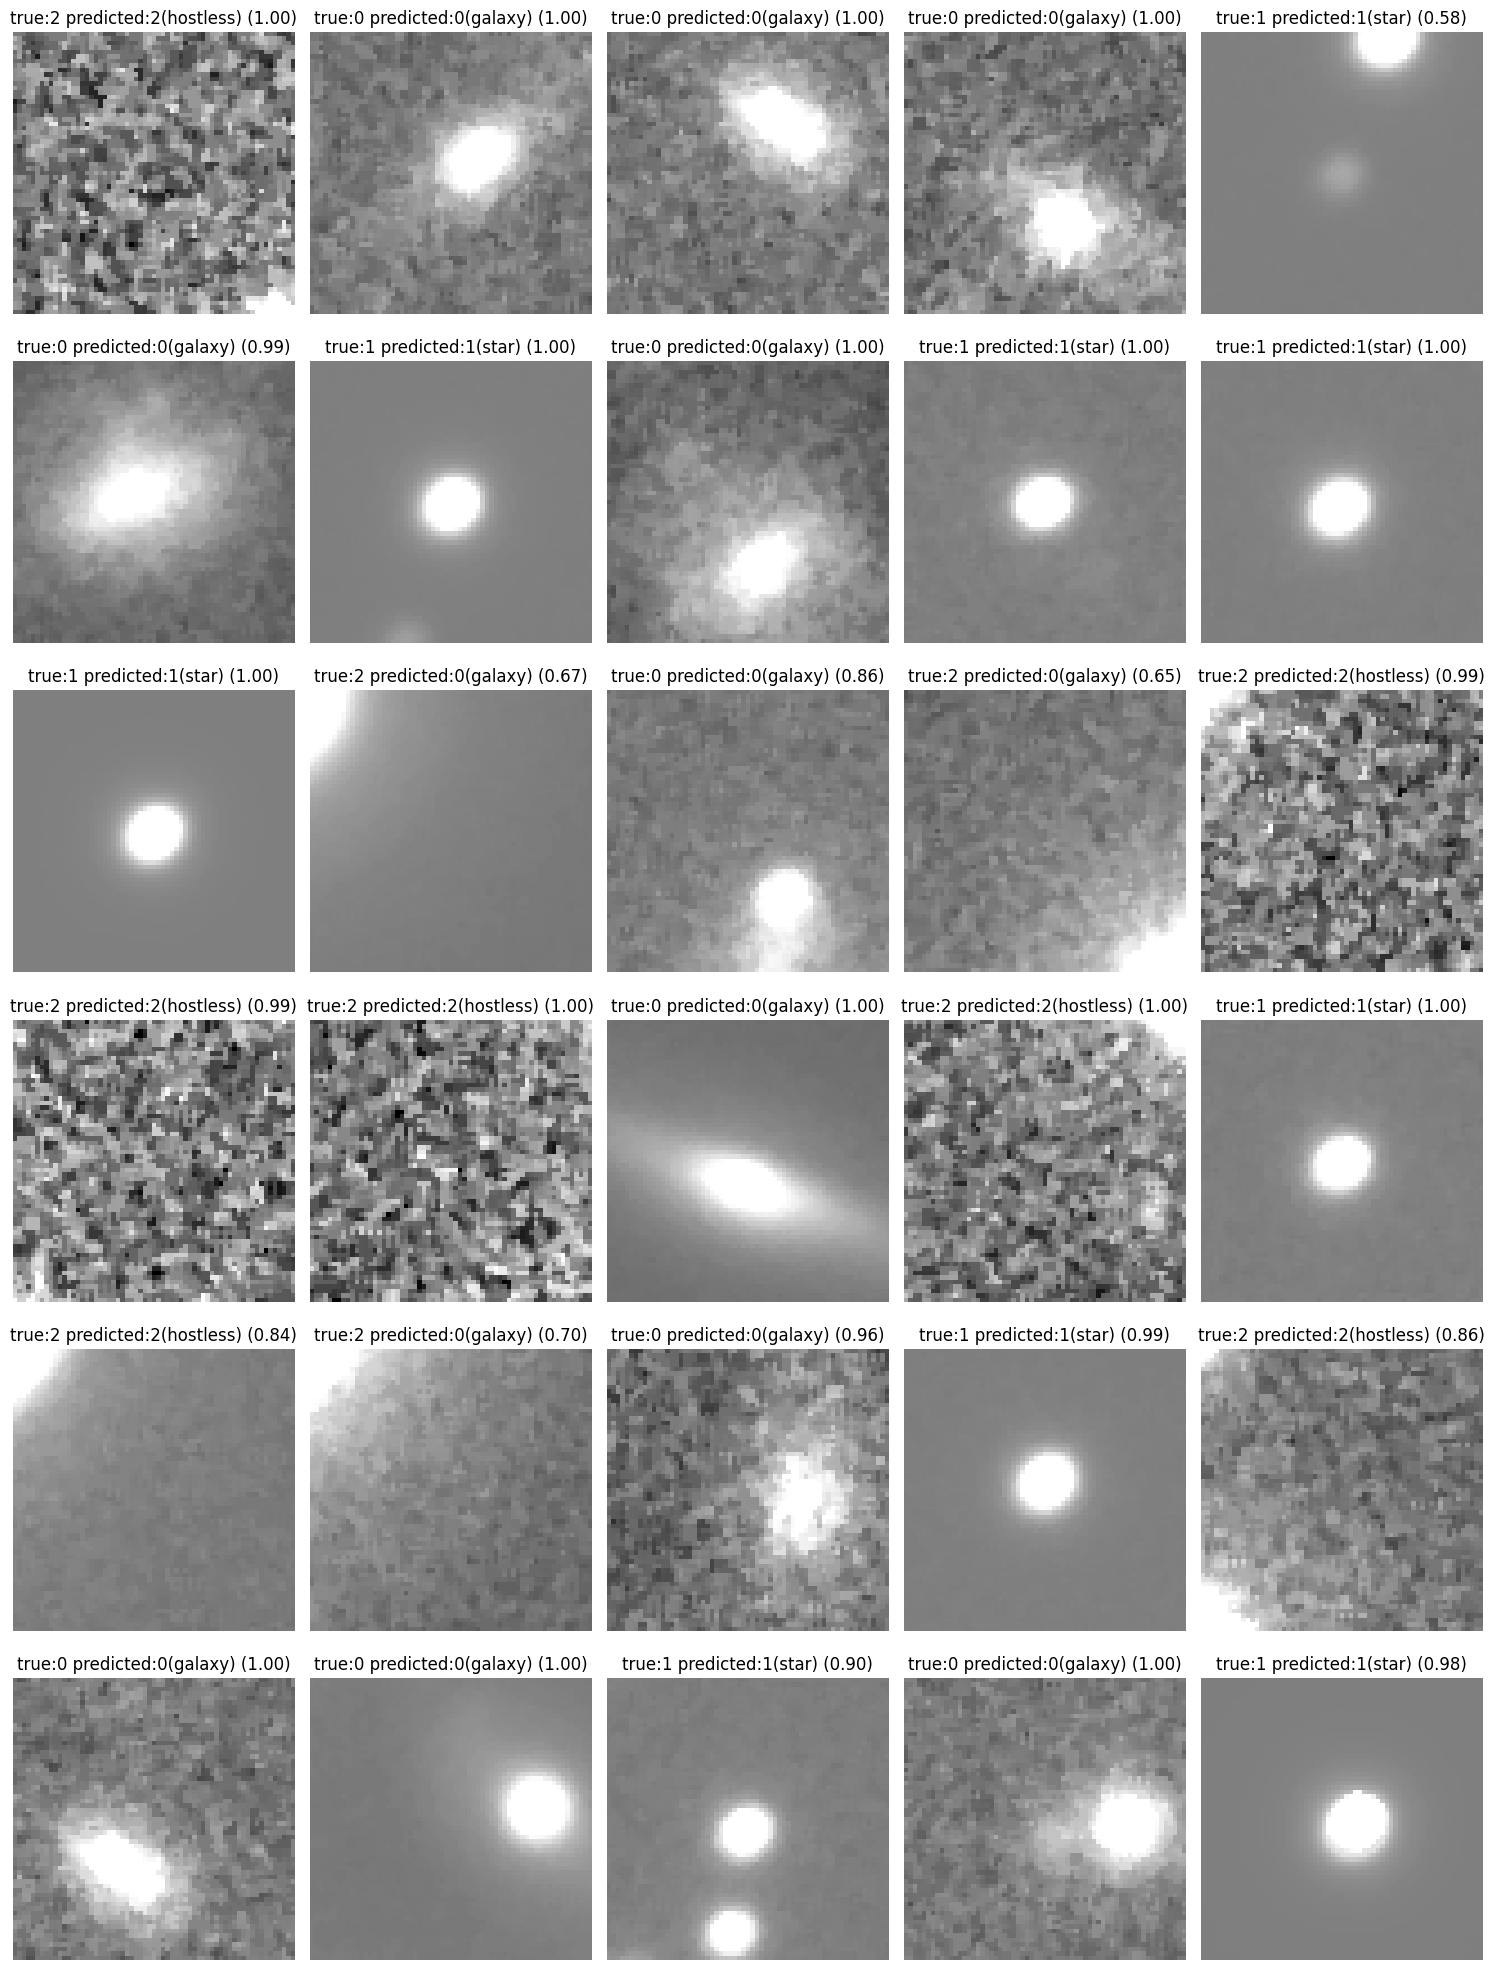

In [74]:

import matplotlib.pyplot as plt
%matplotlib inline
from astropy.stats import sigma_clipped_stats
# Set up the figure
plt.figure(figsize=(15,20))  

# Plot 20 images in a 4x5 grid

for i in range(30):
    
    plt.subplot(6, 5, i + 1)  # 4 rows, 5 columns
    median=np.median(ILMT_cuts[i])
    mean=np.mean(ILMT_cuts[i])
    plt.imshow(ILMT_cuts[i],vmin=median-3*std,vmax=median+3*std,cmap='gray',interpolation='none')
    # plt.title(f"{labels[i]}: {str_label[labels[i]]}{(np.max(predictions[i]))*100}%")
    plt.title(f"true:{np.array(cut_labels)[i]} predicted:{pred_labels[i]}({str_label[pred_labels[i]]}) ({np.max(predictions[i]):.2f})")

    plt.axis('off')  # hiding axes for clarity

plt.tight_layout()
plt.show()